In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pymc3 as pm

sns.set(style="ticks", context='poster')
%matplotlib inline

RANDOM_SEED = 8927

In [2]:
MF_counts = pd.read_csv('./MF_count_2.csv')

In [3]:
strains = ['RS5348', 'RSA133', 'RSA622', 'RSA645', 'RSC019', 'RSC033', 'RSD029']

In [2]:
def find_binom_HDI(count_data, strain, diet=False):
    if not diet:
        n_success = count_data[count_data['Strain'] == strain]['Eu'].sum()
        total = count_data[count_data['Strain'] == strain]['Total'].sum()
    else:
        n_success = count_data[(count_data['Strain'] == strain) & (count_data['Culture']==diet)]['Eu'].sum()
        total = count_data[(count_data['Strain'] == strain) & (count_data['Culture']==diet)]['Total'].sum()
    data_0 = np.zeros(total - n_success)
    data_1 = np.ones(n_success)
    data = np.concatenate((data_0, data_1))
    with pm.Model() as bin_model:
        p = pm.Beta('p', alpha=1, beta=1)
        obs = pm.Bernoulli('obs', p=p, observed =data)
        trace = pm.sample(10000, tune=4000, random_seed=RANDOM_SEED, return_inferencedata=False)
        stat_results = az.summary(trace, round_to=2, hdi_prob=0.95)
        az.plot_trace(trace)
    return stat_results

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 14 seconds.


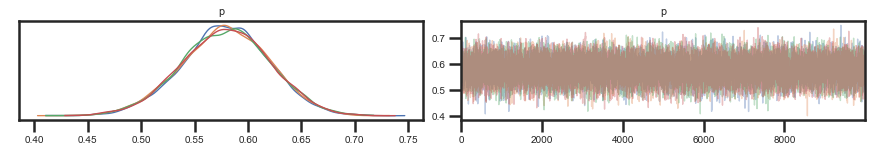

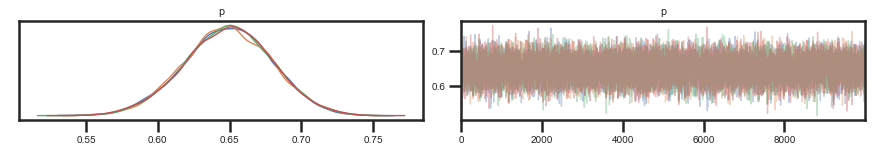

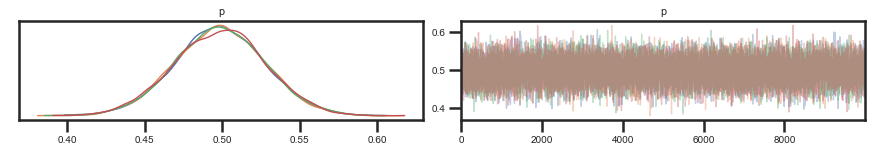

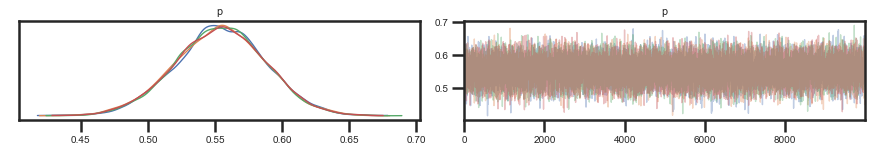

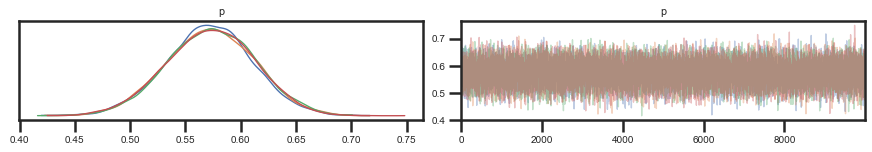

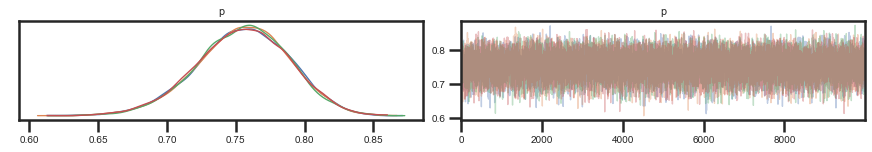

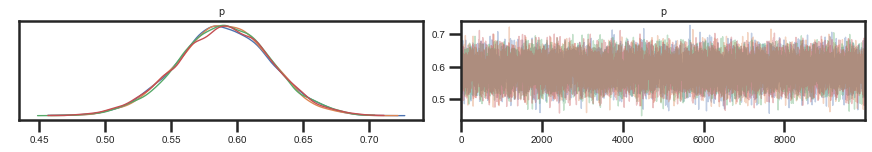

In [5]:
data = {}
for i in strains:
    data[i] = find_binom_HDI(MF_counts, i)

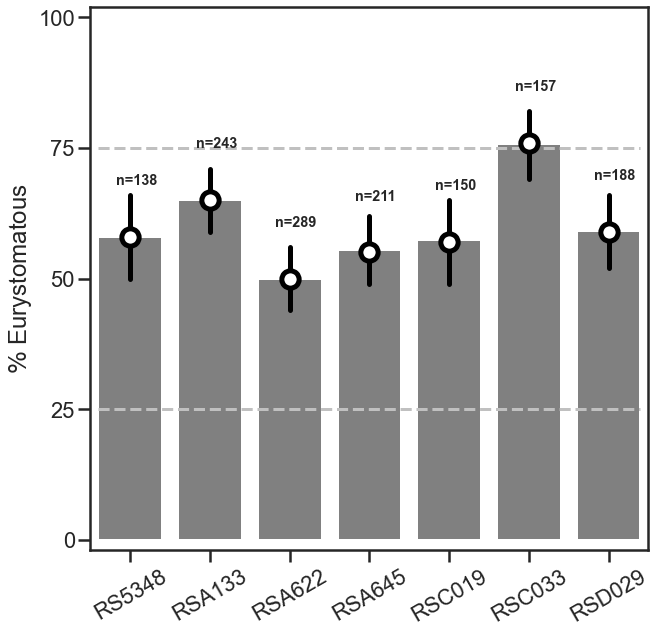

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

space=0
for i in strains:
    plt.vlines(space, float(data[i]['hdi_2.5%']), float(data[i]['hdi_97.5%']),  colors='black', linestyles='-', linewidth=5, capstyle='round', label='95% HDI',clip_on=False, zorder=3)
    plt.scatter(space, float(data[i]['mean']), zorder=3, s=300, edgecolors='black', color='white', linewidths=5)
    txt = 'n='+str(MF_counts[MF_counts['Strain'] == i]['Total'].sum())
    plt.text(space-0.18, float(data[i]['mean'])+0.1, txt, fontsize='x-large', fontweight='heavy')
    space += 1
plt.ylim(-0.02,1.02)
plt.xlim(-0.5, 6.5)
plt.ylabel(r'$\%$ Eurystomatous')
ax.set_xticks(np.arange(0, 7, 1))
ax.set_xticklabels(strains, rotation=30)

heights = [MF_counts[MF_counts['Strain'] == i]['Eu'].sum()/MF_counts[MF_counts['Strain'] == i]['Total'].sum() for i in strains]
plt.bar(range(7), heights, zorder=1, color='gray')


ax.set_yticks(np.linspace(0,1, 5))
ax.set_yticklabels([0, 25, 50, 75, 100])

# plt.hlines(0.5, -0.2, 6.2, zorder=0, linestyles='--', color='silver')
plt.hlines(0.75, -0.4, 6.4, zorder=2, linestyles='--', color='silver')
plt.hlines(0.25, -0.4, 6.4, zorder=2, linestyles='--', color='silver')
plt.savefig('./fig2b.jpeg', bbox_inches='tight', dpi=300)

In [33]:
def bayesian_robust_two_groups(sample_1, sample_2):
    pooled = np.concatenate([sample_1, sample_2])
    m_s = np.mean(pooled)
    std_s = np.std(pooled) * 2
    σ_low = 1
    σ_high = 300
    n1 = len(sample_1)
    n2 = len(sample_2)
    with pm.Model() as model:
        group1_mean = pm.Normal("group1_mean", mu=m_s, sd=std_s)
        group2_mean = pm.Normal("group2_mean", mu=m_s, sd=std_s)
        group1_std = pm.Uniform("group1_std", lower=σ_low, upper=σ_high)
        group2_std = pm.Uniform("group2_std", lower=σ_low, upper=σ_high)
        ν = pm.Exponential("ν_minus_one", 1 / 29.0) + 1
        λ1 = group1_std ** -2
        λ2 = group2_std ** -2
        group1 = pm.StudentT("observed1", nu=ν, mu=group1_mean, lam=λ2, observed=sample_1)
        group2 = pm.StudentT("observed2", nu=ν, mu=group2_mean, lam=λ1, observed=sample_2)
        diff_of_means = pm.Deterministic("difference of means", group1_mean - group2_mean)
        diff_of_stds = pm.Deterministic("difference of stds", group1_std - group2_std)
        # effect_size = pm.Deterministic(
        #     "effect size", diff_of_means / np.sqrt((group1_std ** 2 + group2_std ** 2) / 2)
        # )
        effect_size = pm.Deterministic(
            "effect size", diff_of_means / np.sqrt((group1_std ** 2 * (n1 - 1) + group2_std ** 2 * (n2 - 1)) / (n1 + n2 - 2)))

        
    with model:
        trace = pm.sample(10000, random_seed=RANDOM_SEED, return_inferencedata=False)
    with model:
        stat_results = az.summary(trace, round_to=2, hdi_prob=0.95)
    with model:
        data = az.convert_to_dataset(trace)
    diff_dist = np.array(data['difference of means']).flatten()
    prop = np.round(len([i for i in diff_dist if i > 0])/len(diff_dist), decimals=2)
    return stat_results, prop

In [4]:
intra_strain_f = pd.read_excel('../github_files/raw_data/fig2/fecundity_within_strain.xlsx')

In [5]:
strains = ['RS5348', 'RSA113', 'RSA622', 'RSA645', 'RSC019', 'RSC033', 'RSD029']
stat_dic = {}
diff_positive = {}
for strain in strains:
    sample_1 = intra_strain_f[(intra_strain_f['Strain']==strain) & (intra_strain_f['MF']=='St')]['Fecundity']
    sample_2 = intra_strain_f[(intra_strain_f['Strain']==strain) & (intra_strain_f['MF']=='Eu')]['Fecundity']
    output = bayesian_robust_two_groups(sample_1, sample_2)
    stat_dic[strain], diff_positive[strain] = output

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.


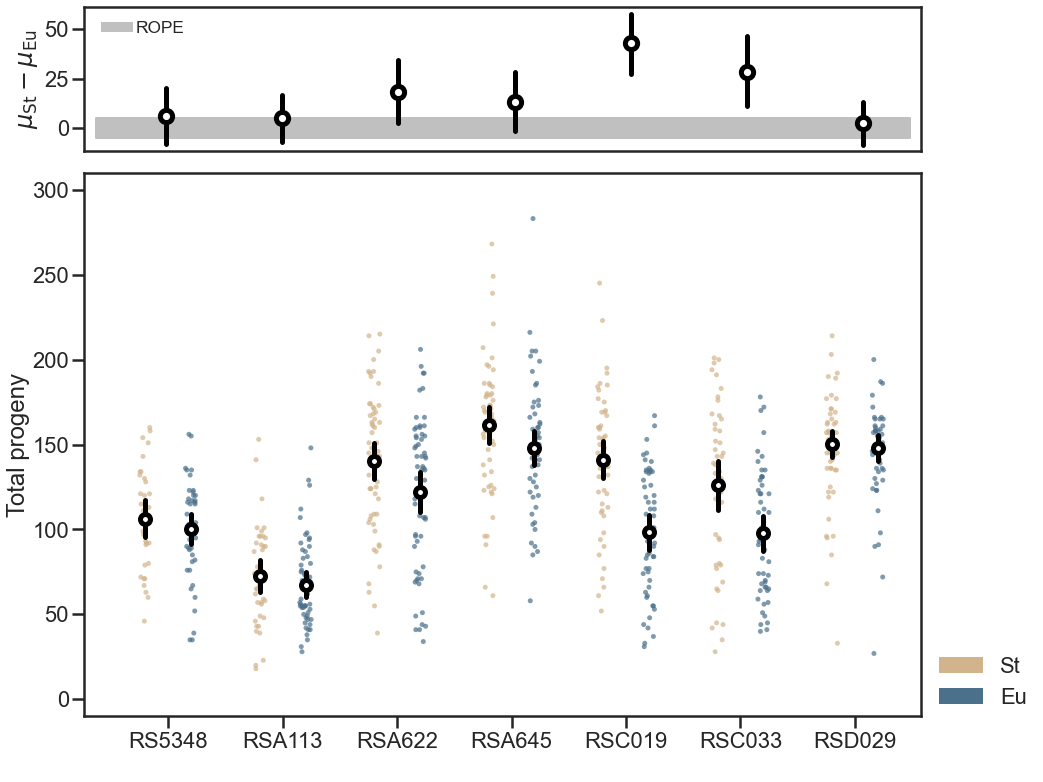

In [6]:
fig = plt.figure(figsize=(15,10))

g = sns.stripplot(data=intra_strain_f, x="Strain", y="Fecundity", hue="MF",palette={"Eu": "#4a708bff", "St": "#d2b48cff"}, zorder=0, hue_order=['St', 'Eu'], dodge=True, alpha=0.7)
space = 0
for i in strains:
    plt.vlines(-0.2+space, stat_dic[i]['hdi_2.5%']['group1_mean'], stat_dic[i]['hdi_97.5%']['group1_mean'],  colors='black', linestyles='-', linewidth=5, capstyle='round',clip_on=False, zorder=10)
    plt.scatter(-0.2+space, stat_dic[i]['mean']['group1_mean'], s=100, edgecolors='black', color='white', linewidths=5, zorder=12)
    plt.vlines(0.2+space, stat_dic[i]['hdi_2.5%']['group2_mean'], stat_dic[i]['hdi_97.5%']['group2_mean'],  colors='black', linestyles='-', linewidth=5, capstyle='round',clip_on=False, zorder=10)
    plt.scatter(0.2+space, stat_dic[i]['mean']['group2_mean'], s=100, edgecolors='black', color='white', linewidths=5, zorder=12)
    space += 1

plt.xlabel(r' ',labelpad=0)
plt.ylabel(r'Total progeny',labelpad=2)

plt.bar(0,0, edgecolor='black',linewidth=0, color= "#d2b48cff", label="St")
plt.bar(0,0, edgecolor='black',linewidth=0, color= "#4a708bff", label="Eu")

handles, labels = plt.gca().get_legend_handles_labels()

plt.legend(handles[2:], labels[2:], loc=(1.01,0),frameon=False, edgecolor='white')

plt.ylim(-10, 310)

ax2 = fig.add_axes([0.125, 0.91, 0.775, 0.2])
space=0
for i in strains:
    ax2.vlines(space, stat_dic[i]['hdi_2.5%']['difference of means'], stat_dic[i]['hdi_97.5%']['difference of means'],  colors='black', linestyles='-', linewidth=5, capstyle='round',clip_on=False, zorder=10)
    ax2.scatter(space, stat_dic[i]['mean']['difference of means'], s=150, edgecolors='black', color='white', linewidths=5, zorder=12)
    space+= 1
x = np.linspace(-0.6, 6.4, 10)
ax2.fill_between(x, [5 for i in x], [-5 for i in x], color='silver')
ax2.bar(-10,0, color= "silver", label="ROPE")

ax2.legend(loc=(0.01,0.75),frameon=False, edgecolor='white', fontsize='xx-large', handletextpad=0.1)
ax2.set_xlim(-0.7, 6.5)
ax2.set_xticks(np.arange(0, len(strains), 1))
ax2.set_xticklabels([])
ax2.tick_params(axis='x', length=15)

ax2.set_ylabel(r'$\mu_{\mathrm{St}} - \mu_{\mathrm{Eu}}$')
plt.savefig('./fig2c.jpeg', bbox_inches='tight', dpi=300)

In [16]:
df = pd.concat([stat_dic[i] for i in strains], axis=0, keys=strains)

In [17]:
df.to_latex('./test.tex')

In [18]:
MF_counts_2 = pd.read_csv('../revision/MF_count_3.csv')

In [26]:
MF_counts_2['Eu_pre'] = MF_counts_2['Eu']/MF_counts_2['Total']

In [27]:
MF_counts_2.head()

,Strain,Culture,Eu,Total,rep,prop,Eu_pre
0,RSC019,OP50,33,50,1,66,0.66
1,RSC019,OP50,30,50,2,60,0.60
2,RSC019,OP50,23,50,3,46,0.46
3,RSC017,OP50,1,50,1,2,0.02
4,RSC017,OP50,5,50,2,10,0.10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 14 seconds.


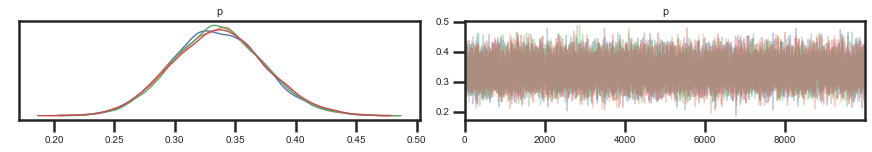

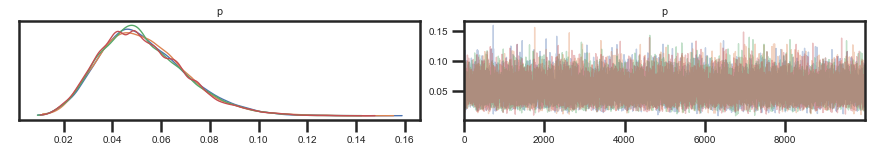

In [22]:
strains = ['RSC011', 'RSC017']

data = {}
for i in strains:
    data[i] = find_binom_HDI(MF_counts_2, i)

<Figure size 432x288 with 0 Axes>

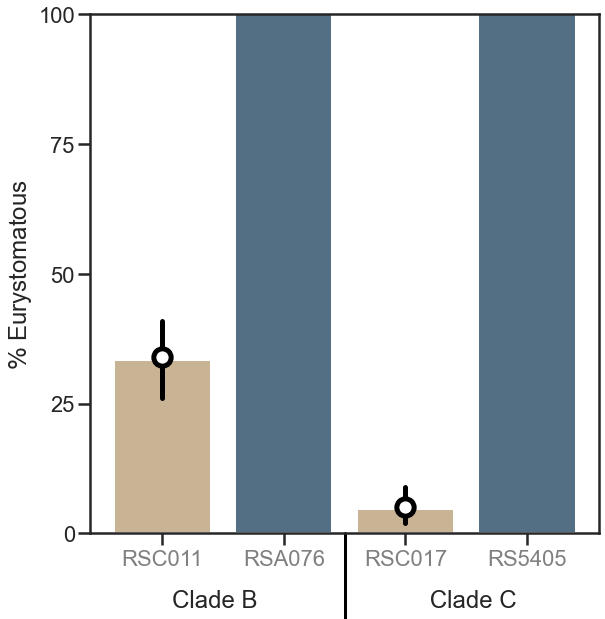

In [28]:
fig = plt.figure()

g = sns.catplot(data=MF_counts_2, aspect=1, ci = None, palette= ["#d2b48cff" , "#4a708bff", "#d2b48cff", "#4a708bff"], order=['RSC011','RSA076', 'RSC017', 'RS5405'], x="Strain", y='Eu_pre',  kind="bar", alpha=1, height=8,clip_on=True)
g.set_xticklabels(rotation=0, color='grey')


plt.bar(0,0, color= "#4a708bff", label="Eu biased")
plt.bar(0,0, color= "#d2b48cff", label="St biased")

plt.yticks(np.linspace(0,1, 5), labels=[0, 25, 50, 75, 100])

space=0
for i in strains:
    plt.vlines(space, float(data[i]['hdi_2.5%']), float(data[i]['hdi_97.5%']),  colors='black', linestyles='-', linewidth=5, capstyle='round', label='95% HDI',clip_on=False, zorder=2)
    plt.scatter(space, float(data[i]['mean']), zorder=2, s=300, edgecolors='black', color='white', linewidths=5)
    space += 2

plt.vlines(1.5, -30,0,  colors='black', linestyles='-', linewidth=3, capstyle='round',clip_on=False)

sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)


plt.ylim(0, 1)
g.set_ylabels(r'$\%$ Eurystomatous')
g.set_xlabels(r'Clade B                          Clade C', labelpad=20)
plt.savefig('./fig2d.jpeg', bbox_inches='tight', dpi=300)

In [29]:
fec_clades = pd.read_excel('../github_files/raw_data/fig2/fecundity_between_strains.xlsx')

In [30]:
strains = [('RSC011', 'RSA076'), ('RSC017', 'RS5405'), ('RSC011', 'RS5405'), ('RSC017', 'RSA076')]
stat_dic = {}
diff_positive = {}
for strain in strains:
    sample_1 = fec_clades[fec_clades['Strain']==strain[0]]['Progeny Count']
    sample_2 = fec_clades[fec_clades['Strain']==strain[1]]['Progeny Count']
    output = bayesian_robust_two_groups(sample_1, sample_2)
    stat_dic[strain], diff_positive[strain] = output

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 22 seconds.


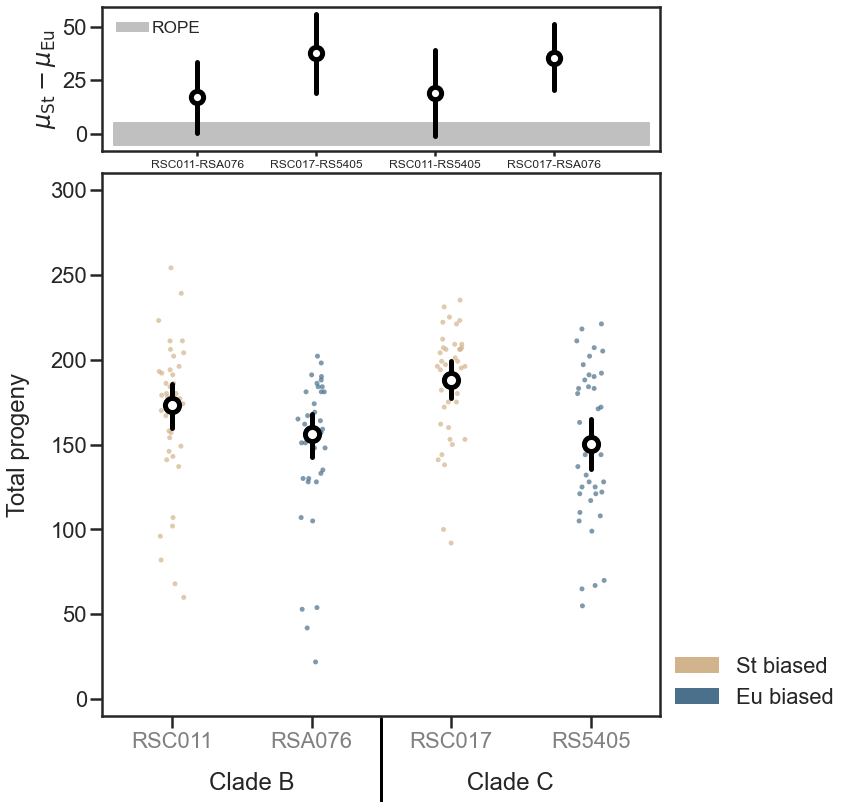

In [31]:
fig = plt.figure(figsize=(10,10))

g = sns.stripplot(data=fec_clades, x="Strain", y="Progeny Count",palette= ["#d2b48cff" , "#4a708bff", "#d2b48cff", "#4a708bff"], order=['RSC011','RSA076', 'RSC017', 'RS5405'], zorder=0, dodge=True, alpha=0.7)

space=0
for i in [('RSC011', 'RSA076'), ('RSC017', 'RS5405')]:
    plt.vlines(space, float(stat_dic[i]['hdi_2.5%']['group1_mean']), float(stat_dic[i]['hdi_97.5%']['group1_mean']),  colors='black', linestyles='-', linewidth=5, capstyle='round', clip_on=False, zorder=2)
    plt.scatter(space, float(stat_dic[i]['mean']['group1_mean']), zorder=2, s=200, edgecolors='black', color='white', linewidths=5)
    plt.vlines(space+1, float(stat_dic[i]['hdi_2.5%']['group2_mean']), float(stat_dic[i]['hdi_97.5%']['group2_mean']),  colors='black', linestyles='-', linewidth=5, capstyle='round', clip_on=False, zorder=2)
    plt.scatter(space+1, float(stat_dic[i]['mean']['group2_mean']), zorder=2, s=200, edgecolors='black', color='white', linewidths=5)
    space += 2
    
plt.xlabel(r'Wild isolates',labelpad=20)
plt.ylabel(r'Total progeny',labelpad=20)
plt.ylim(0, 300)
plt.xlabel(r'Clade B                          Clade C', labelpad=20)
plt.vlines(1.5, -70, -11,  colors='black', linestyles='-', linewidth=3, capstyle='round',clip_on=False)
plt.xticks(color='grey')

plt.bar(0,0, edgecolor='black',linewidth=0, color= "#d2b48cff", label="St biased")
plt.bar(0,0, edgecolor='black',linewidth=0, color= "#4a708bff", label="Eu biased")


plt.legend(loc=(1.01,0),frameon=False)

plt.ylim(-10, 310)
plt.xlim(-0.5,3.5)

ax2 = fig.add_axes([0.125, 0.91, 0.775, 0.2])
space=0.1
for i in strains:
    ax2.vlines(space, stat_dic[i]['hdi_2.5%']['difference of means'], stat_dic[i]['hdi_97.5%']['difference of means'],  colors='black', linestyles='-', linewidth=5, capstyle='round',clip_on=False, zorder=10)
    ax2.scatter(space, stat_dic[i]['mean']['difference of means'], s=150, edgecolors='black', color='white', linewidths=5, zorder=12)
    space+= 1.
x = np.linspace(-0.6, 3.9, 10)
ax2.fill_between(x, [5 for i in x], [-5 for i in x], color='silver')
ax2.set_xlim(-0.7, 4)
ax2.set_xticks(np.arange(0, len(strains), 1)+0.1)
ax2.set_xticklabels(['RSC011-RSA076', 'RSC017-RS5405', 'RSC011-RS5405', 'RSC017-RSA076'], fontsize='large')
ax2.tick_params(axis='x', length=5)
ax2.set_ylabel(r'$\mu_{\mathrm{St}} - \mu_{\mathrm{Eu}}$')

ax2.bar(-10,0, color= "silver", label="ROPE")

ax2.legend(loc=(0.01,0.75),frameon=False, edgecolor='white', fontsize='xx-large', handletextpad=0.1)

plt.savefig('./fig2e.jpeg', bbox_inches='tight', dpi=300)

In [32]:
df = pd.concat([stat_dic[i] for i in strains], axis=0, keys=strains)

In [33]:
df.head()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  \
RSC011 RSA076 group1_mean  173.11   6.60    159.80     185.68       0.05   
              group2_mean  155.91   6.49    142.80     168.20       0.05   
              group1_std    31.45   7.53     18.36      46.26       0.07   
              group2_std    34.38   7.33     20.79      48.86       0.06   
              ν_minus_one    8.20  14.79      0.05      34.74       0.12   

                           mcse_sd  ess_mean    ess_sd  ess_bulk  ess_tail  \
RSC011 RSA076 group1_mean     0.03  20055.49  20055.49  20307.51  20799.06   
              group2_mean     0.04  17058.45  17058.45  17493.96  19034.09   
              group1_std      0.05  12754.75  12754.75  12672.96  17474.07   
              group2_std      0.04  13767.41  13767.41  13532.92  16649.57   
              ν_minus_one     0.08  16354.65  16354.65  11972.32  18171.42   

                           r_hat  
RSC011 RSA076 group1_mean    1.0  
              group2_mean    1.0  
              group1_std     1.0  
              group2_std     1.0  
              ν_minus_one    1.0

In [34]:
df.to_latex('./table_s7.tex')

# Fig 3a

In [17]:
mf_isolate = pd.read_csv('../github_files/raw_data/fig3/MF_on_novo_op50_n2.csv')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 4_000 tune and 10_000 draw iterations (16_000 + 40_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 4_000 tune and 10_000 draw iterations (16_000 + 40_000 draws total) took 14 seconds.


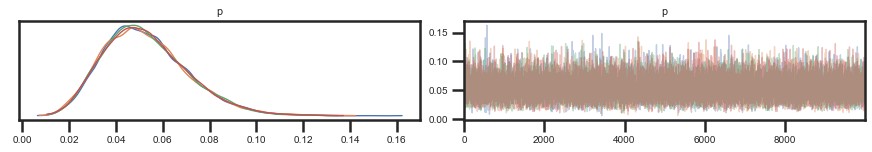

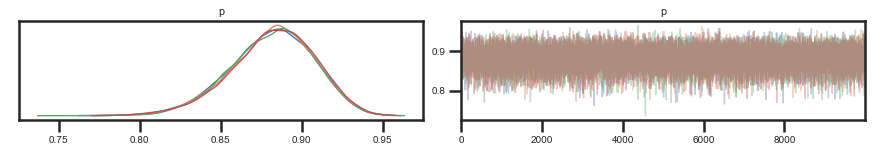

In [4]:
strain = 'RSC017'

data = {}
name = strain + '_op50'
data[name] = find_binom_HDI(mf_isolate, strain, 'OP50')
name = strain + '_novo'
data[name] = find_binom_HDI(mf_isolate, strain, 'Novo')

In [18]:
mf_isolate['Prop'] = mf_isolate['Prop']/100

<Figure size 720x720 with 0 Axes>

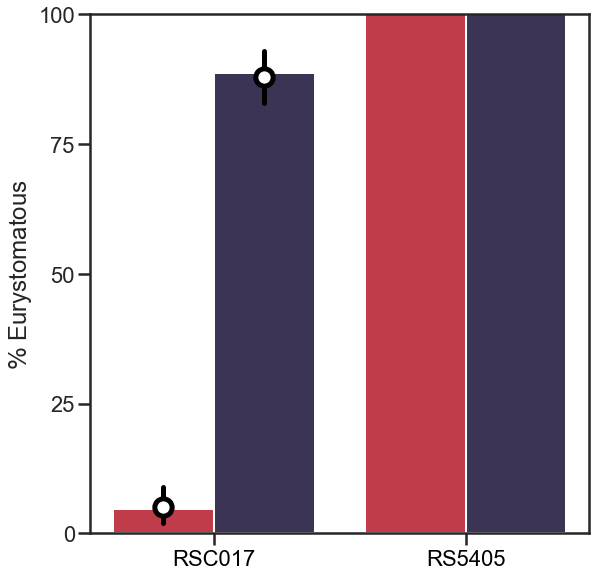

In [30]:
fig = plt.figure(figsize=(10,10))
g = sns.catplot(data=mf_isolate, aspect=1, x="Strain", y='Prop', kind="bar", ci=None, hue='Culture',order=['RSC017','RS5405'], alpha=1, height=8, palette={"Novo": '#392F5A', "OP50": '#D72638'})
g._legend.remove()
g.set_xticklabels(rotation=0, color='black')

g.set_ylabels(r'$\%$ Eurystomatous')
g.set_xlabels(r'', labelpad=10)

plt.yticks(np.linspace(0,1, 5), labels=[0, 25, 50, 75, 100])

plt.vlines(-0.2, float(data['RSC017_op50']['hdi_2.5%']), float(data['RSC017_op50']['hdi_97.5%']),  colors='black', linestyles='-', linewidth=5, capstyle='round', label='95% HDI',clip_on=False, zorder=2)
plt.scatter(-0.2, float(data['RSC017_op50']['mean']), zorder=2, s=300, edgecolors='black', color='white', linewidths=5)

plt.vlines(0.2, float(data['RSC017_novo']['hdi_2.5%']), float(data['RSC017_novo']['hdi_97.5%']),  colors='black', linestyles='-', linewidth=5, capstyle='round', label='95% HDI',clip_on=False, zorder=2)
plt.scatter(0.2, float(data['RSC017_novo']['mean']), zorder=2, s=300, edgecolors='black', color='white', linewidths=5)    
    
# plt.vlines(j, float(data[i+'_op50']['hdi_2.5%']), float(data[i+'_op50']['hdi_97.5%']),  colors='black', linestyles='-', linewidth=5, capstyle='round', label='95% HDI',clip_on=False, zorder=2)
# plt.scatter(j, float(data[i+'_op50']['mean']), zorder=2, s=300, edgecolors='black', color='white', linewidths=5)


# for i,j in zip(strains, [-0.2, 0.8]):
#     plt.vlines(j, float(data[i+'_op50']['hdi_2.5%']), float(data[i+'_op50']['hdi_97.5%']),  colors='black', linestyles='-', linewidth=5, capstyle='round', label='95% HDI',clip_on=False, zorder=2)
#     plt.scatter(j, float(data[i+'_op50']['mean']), zorder=2, s=300, edgecolors='black', color='white', linewidths=5)
    
#     plt.vlines(j + 0.4, float(data[i+'_novo']['hdi_2.5%']), float(data[i+'_novo']['hdi_97.5%']),  colors='black', linestyles='-', linewidth=5, capstyle='round', label='95% HDI',clip_on=False, zorder=2)
#     plt.scatter(j + 0.4, float(data[i+'_novo']['mean']), zorder=2, s=300, edgecolors='black', color='white', linewidths=5)
    

sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)    



handles, labels = plt.gca().get_legend_handles_labels()
plt.ylim(0, 1)
plt.savefig('./fig3a.jpeg', bbox_inches='tight', dpi=300)

# Fig 3b

In [31]:
fec_isolate = pd.read_excel('../github_files/raw_data/fig3/fecundity_novo_op50_n.xlsx')

In [34]:
strains = ['RSC017','RS5405']
stat_dic = {}
diff_positive = {}
for strain in strains:
    sample_1 = fec_isolate[(fec_isolate['Strain']==strain) & (fec_isolate['Culture Condition']=="Novosphingobium sp.")]["Total Progeny Count"]
    sample_2 = fec_isolate[(fec_isolate['Strain']==strain) & (fec_isolate['Culture Condition']=="E. coli ")]["Total Progeny Count"]
    output = bayesian_robust_two_groups(sample_1, sample_2)
    stat_dic[strain], diff_positive[strain] = output

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 25 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 17 seconds.


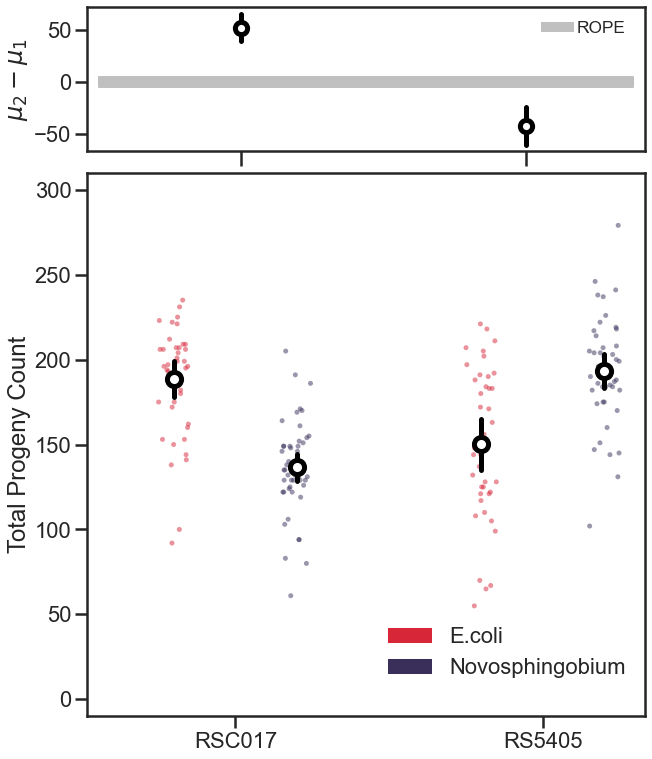

In [70]:
fig = plt.figure(figsize=(10,10))

g = sns.stripplot(data=fec_isolate, x="Strain", y="Total Progeny Count", hue='Culture Condition', hue_order=["E. coli ", "Novosphingobium sp."],  zorder=0, dodge=True, alpha=0.5, order=strains, palette={"E. coli ": '#D72638', "Novosphingobium sp.": '#392F5A'})

space=0.2
for i in strains:
    plt.vlines(space, float(stat_dic[i]['hdi_2.5%']['group1_mean']), float(stat_dic[i]['hdi_97.5%']['group1_mean']),  colors='black', linestyles='-', linewidth=5, capstyle='round', clip_on=False, zorder=2)
    plt.scatter(space, float(stat_dic[i]['mean']['group1_mean']), zorder=2, s=200, edgecolors='black', color='white', linewidths=5)
    plt.vlines(space-0.4, float(stat_dic[i]['hdi_2.5%']['group2_mean']), float(stat_dic[i]['hdi_97.5%']['group2_mean']),  colors='black', linestyles='-', linewidth=5, capstyle='round', clip_on=False, zorder=2)
    plt.scatter(space-0.4, float(stat_dic[i]['mean']['group2_mean']), zorder=2, s=200, edgecolors='black', color='white', linewidths=5)
    space += 1
plt.ylim(-10, 310)

plt.xlabel(r'',labelpad=20)
plt.bar(0,0, edgecolor='black',linewidth=0, color= '#D72638', label="E.coli")
plt.bar(0,0, edgecolor='black',linewidth=0, color= '#392F5A', label="Novosphingobium")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[2:], labels[2:], bbox_to_anchor=(1.001, 0.2),frameon=False)

ax2 = fig.add_axes([0.125, 0.91, 0.775, 0.2])
for i,j in zip(strains, [0.6, 3]):
    ax2.vlines(j, -1*stat_dic[i]['hdi_2.5%']['difference of means'], -1*stat_dic[i]['hdi_97.5%']['difference of means'],  colors='black', linestyles='-', linewidth=5, capstyle='round',clip_on=False, zorder=10)
    ax2.scatter(j, -1*stat_dic[i]['mean']['difference of means'], s=150, edgecolors='black', color='white', linewidths=5, zorder=12)

x = np.linspace(-0.6, 3.9, 10)
ax2.fill_between(x, [5 for i in x], [-5 for i in x], color='silver')

ax2.bar(-10,0, color= "silver", label="ROPE")

ax2.legend(loc=(0.8,0.75),frameon=False, edgecolor='white', fontsize='xx-large', handletextpad=0.1)

ax2.set_ylabel(r'$\mu_2 - \mu_{1}$')


ax2.set_xlim(-0.7, 4)
ax2.set_xticks([0.6, 3])
ax2.set_xticklabels([])
ax2.tick_params(axis='x', length=15)

plt.savefig('./fig3b.jpeg', bbox_inches='tight', dpi=300)

In [46]:
df = pd.concat([stat_dic[i] for i in strains], axis=0, keys=strains)

In [47]:
df.head()

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
RSC017 group1_mean  136.68   4.03    128.76     144.61       0.02     0.02   
       group2_mean  188.76   5.49    177.72     199.24       0.03     0.02   
       group1_std    30.74   4.76     21.44      40.23       0.03     0.02   
       group2_std    25.78   3.84     18.27      33.49       0.03     0.02   
       ν_minus_one   22.33  24.57      0.54      72.34       0.16     0.11   

                    ess_mean    ess_sd  ess_bulk  ess_tail  r_hat  
RSC017 group1_mean  30134.98  30089.30  30142.38  28043.68    1.0  
       group2_mean  26691.97  26671.53  26679.34  27794.28    1.0  
       group1_std   21145.26  21145.26  20600.88  16254.60    1.0  
       group2_std   18301.01  18301.01  18205.07  14843.09    1.0  
       ν_minus_one  23904.73  23904.73  15621.20  15418.15    1.0

In [48]:
df.to_latex('./table_s8.tex')

In [53]:
dev_isolate = pd.read_excel('../github_files/raw_data/fig3/dev_speed_novo_op50.xlsx')

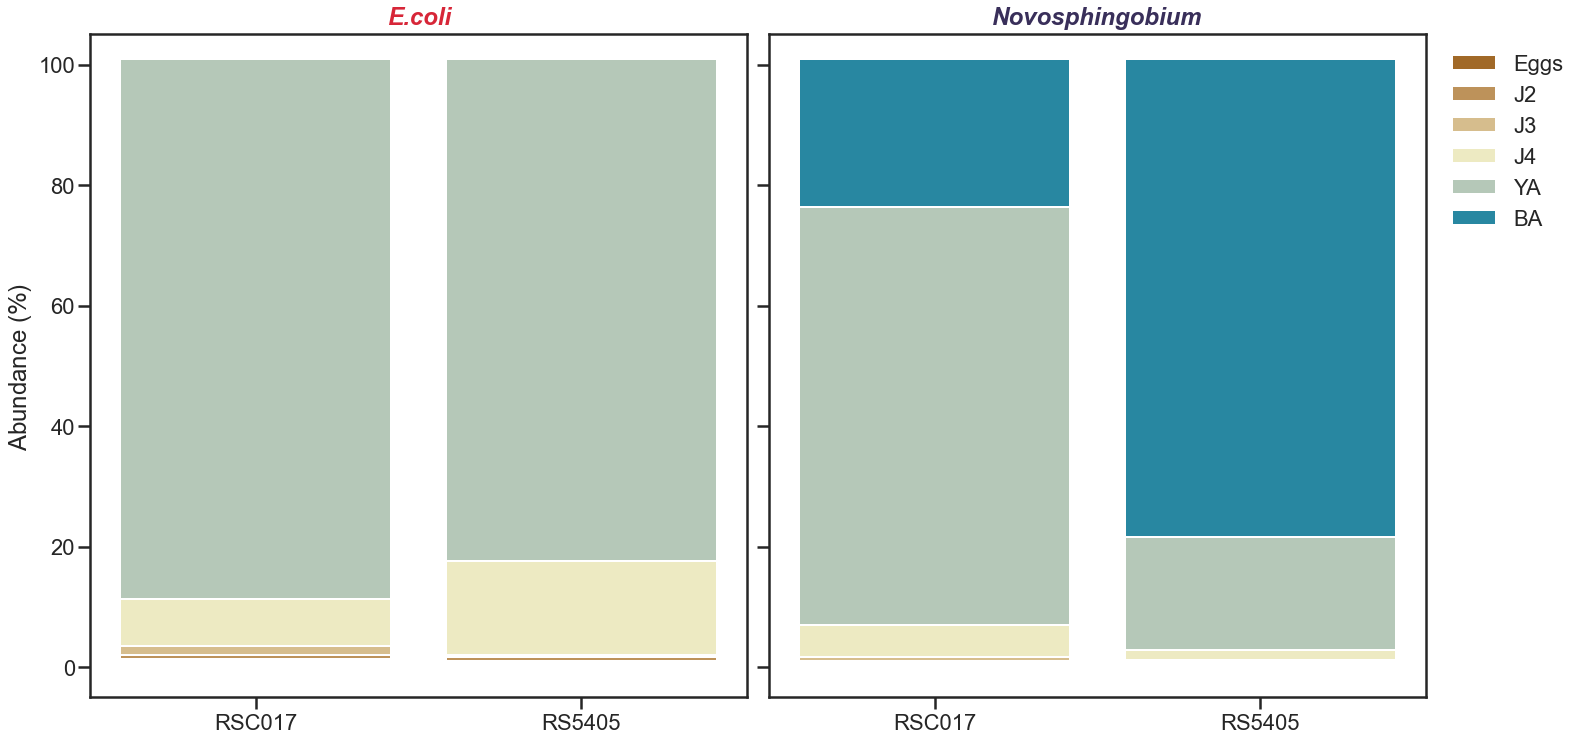

In [69]:
grad = ['#A16928','#bd925a','#d6bd8d','#edeac2','#b5c8b8','#2887a1'] 

fig, ax = plt.subplots(1, 2, figsize=(20,10))

for ind, pos in zip(['RSC017', 'RS5405'], [0, 0.6]):
    count = 0
    bot = 1
    for stage in ['Eggs', 'J2', 'J3', 'J4', 'YA', 'BA']:
        val = dev_isolate[(dev_isolate['Strain']==ind) & (dev_isolate['Stage']==stage) & (dev_isolate['Condition ']=='E.coli')]['Percentage']
        ax[0].bar(pos, val, bottom=bot, color=grad[count], width=0.5)
        bot += float(val)
        count += 1
ax[0].set_ylabel(r'Abundance ($\%$)')
ax[0].set_xticks([0, 0.6])
ax[0].set_xticklabels(['RSC017', 'RS5405'])   

for ind, pos in zip(['RSC017', 'RS5405'], [0, 0.6]):
    count = 0
    bot = 1
    for stage in ['Eggs', 'J2', 'J3', 'J4', 'YA', 'BA']:
        val = dev_isolate[(dev_isolate['Strain']==ind) & (dev_isolate['Stage']==stage) & (dev_isolate['Condition ']=='Novosphingobium sp.')]['Percentage']
        ax[1].bar(pos, val, bottom=bot, color=grad[count], label=stage, width=0.5)
        bot += float(val)
        count += 1
ax[1].set_xticks([0, 0.6])
ax[1].set_xticklabels(['RSC017', 'RS5405']) 
ax[0].set_ylim(-5, 105)
ax[1].set_ylim(-5, 105)
ax[1].set_yticklabels([])
handles, labels = plt.gca().get_legend_handles_labels()
fig.tight_layout()
plt.legend(handles[:6], labels[:6], bbox_to_anchor=(1.01, 1),frameon=False)
ax[0].set_title('E.coli', fontstyle='italic', weight='bold', color='#D72638', pad=10)
ax[1].set_title('Novosphingobium', fontstyle='italic', weight='bold', color='#392F5A', pad=10)
plt.savefig('./fig3c.jpeg', bbox_inches='tight', dpi=300)

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w -p graphviz

Last updated: Mon May 30 2022

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.25.0

graphviz: not installed

pymc3     : 3.9.3
seaborn   : 0.11.1
arviz     : 0.10.0
numpy     : 1.21.0
matplotlib: 3.4.2
pandas    : 1.3.1

Watermark: 2.3.0

